### 라이브러리 import
---
필요한 라이브러리를 import했습니다.\
gensim의 경우 3.8.8로 다운그레이드를 진행했습니다.\
https://iambeginnerdeveloper.tistory.com/41
블로그의 안내대로 pip install --upgrade gensim==3.8.3을 했으나 적용되지 않았습니다.\
그래서 conda uninstall gensim을 한 뒤, 다시 설치했습니다.\
또한 이런 방식을 이용해도 주피터 노트북에 적용되지 않았는데,\
커널을 종료하고 다시 생성해야만 적용될 수 있었습니다.

In [132]:
import os
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import gensim
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant

### 데이터 가져오기
---
노드에 적힌대로 데이터를 가져왔습니다.

In [133]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 로드 함수 및 단어사전 생성
---
노드에 적힌 그대로 생성 했습니다.

In [134]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

print("훈련 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 개수: 146182, 테스트 개수: 49157


In [135]:
index_to_word = {index:word for word, index in word_to_index.items()}

### 문장변환 함수
---
노드에 있던 문장을 벡터로 또 벡터를 문장으로 변환해주는 함수입니다.

In [136]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 모델을 위한 데이터 분석
---
모델의 하이퍼파라미터 설정을 위한 데이터 분석입니다.

In [137]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 데이터 벡터화
---
패딩을 추가하여 길이을 맞춰줍니다.\
노드코드와 달리 pre를 이용하여 더 좋은 학습결과가 나오도록 했습니다.

In [101]:
# padding의 위치에 따라 달라질 수 있다.
# pre
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 모델설계
---
노드에서와 같이 3가지 모델을 모두 설계했습니다.


In [105]:
# RNN 모델 설계
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
print('----------------------')

cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()
print('----------------------')
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(8, activation='relu'))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()
print('----------------------')

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
lstm_18 (LSTM)               (None, 8)                 6688      
_________________________________________________________________
dense_52 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________
----------------------
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, None, 200)         2000000 

### validation set 구성
---
validation set은 20000건으로 구성했습니다.

In [106]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지
partial_x_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


### 모델 훈련 개시
---
각 모델은 시각화를 위해 epoch을 20회 진행했습니다.

In [107]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

print('----------------------')
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_cnn = cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

print('----------------------')
simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 9s 29ms/step - loss: 0.5521 - accuracy: 0.7372 - val_loss: 0.3527 - val_accuracy: 0.8493
Epoch 2/20
247/247 [==============================] - 7s 27ms/step - loss: 0.3238 - accuracy: 0.8666 - val_loss: 0.3422 - val_accuracy: 0.8525
Epoch 3/20
247/247 [==============================] - 7s 27ms/step - loss: 0.2890 - accuracy: 0.8830 - val_loss: 0.3354 - val_accuracy: 0.8572
Epoch 4/20
247/247 [==============================] - 7s 27ms/step - loss: 0.2611 - accuracy: 0.8950 - val_loss: 0.3375 - val_accuracy: 0.8583
Epoch 5/20
247/247 [==============================] - 7s 27ms/step - loss: 0.2341 - accuracy: 0.9074 - val_loss: 0.3425 - val_accuracy: 0.8587
Epoch 6/20
247/247 [==============================] - 7s 27ms/step - loss: 0.2134 - accuracy: 0.9166 - val_loss: 0.3621 - val_accuracy: 0.8566
Epoch 7/20
247/247 [==============================] - 7s 27ms/step - loss: 0.1929 - accuracy: 0.9261 - val_loss: 0.3713 - val_accuracy: 0.8569

Epoch 18/20
247/247 [==============================] - 5s 22ms/step - loss: 0.2554 - accuracy: 0.8942 - val_loss: 0.3903 - val_accuracy: 0.8411
Epoch 19/20
247/247 [==============================] - 6s 22ms/step - loss: 0.2546 - accuracy: 0.8951 - val_loss: 0.3961 - val_accuracy: 0.8414
Epoch 20/20
247/247 [==============================] - 5s 21ms/step - loss: 0.2485 - accuracy: 0.8969 - val_loss: 0.4030 - val_accuracy: 0.8419


### 모델 훈련 결과
---
모델의 훈련 결과는 요구하는 값에 미치지 못 하였습니다.\
epoch값을 줄이면 도달할 수 있을 것도 같습니다.\
중간에 오버피팅이 발생했기 때문입니다.

In [109]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)
print("--------------------------")
print("CNN")
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)
print("--------------------------")
print("GlobalAveragePooling1D layer")
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

1537/1537 - 5s - loss: 0.7317 - accuracy: 0.8363
[0.7317453622817993, 0.8363000154495239]
--------------------------
CNN
1537/1537 - 3s - loss: 1.2277 - accuracy: 0.8267
[1.227718472480774, 0.8267388343811035]
--------------------------
GlobalAveragePooling1D layer
1537/1537 - 3s - loss: 0.4078 - accuracy: 0.8363
[0.4077545404434204, 0.8363407254219055]


### lstm 모델 시각화
---
lstm 모델은 약 2epoch 이후부터 overfitting이 발생하는 것 같습니다.

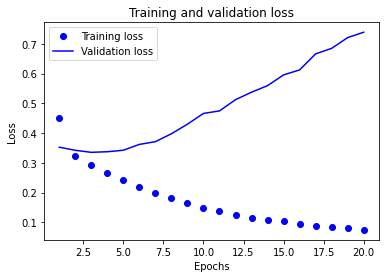

In [110]:
history_dict = history.history
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

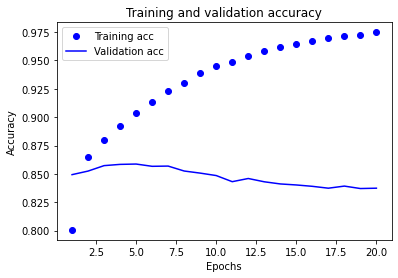

In [111]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### cnn 모델 시각화
---
cnn 모델도 약 2epoch 이후부터 overfitting이 발생하는 것 같습니다.

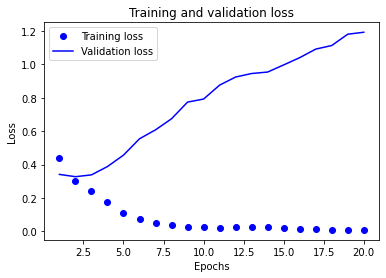

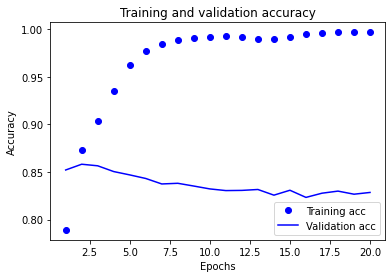

In [112]:
history_dict = history_cnn.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling 모델 시각화
---
GlobalMaxPooling 모델도 약 2epoch 이후부터 overfitting이 발생하는 것 같습니다.
세 모델 모두 많은 학습회수가 필요하지 않은 것 같습니다.

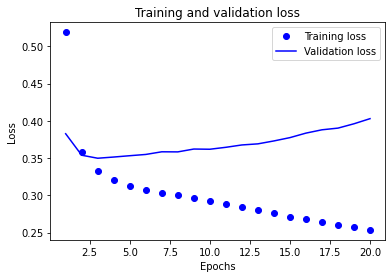

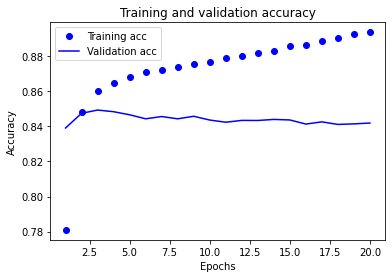

In [113]:
history_dict = history_simple.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [114]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


### word2vec 적용
---
앞서 라이브러리에서 설명한대로 많은 시행착오가 있었던 부분입니다.\
처음에는 tsv파일을 이용해야 된다고 생각했습니다.


In [115]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.tsv'
word2vec_data = pd.read_csv(word2vec_file_path, delimiter='\t')
word2vec_data


,0,하,[ 1.2513299 -0.79136038 -1.73257852 -0.10256522 0.49739066 -0.6211493
0,-0.75320292 -0.73639965 -0.48074064 -2.717918...,NaN,NaN
1,-1.31397796 -1.23559558 2.00065851 -1.614447...,NaN,NaN
2,-0.31341434 -0.84969783 -1.16742218 3.886214...,NaN,NaN
3,1.61381435 1.22231627 -1.98783004 0.164879...,NaN,NaN
4,-0.49372947 0.26293227 -1.1739614 -0.711869...,NaN,NaN
...,...,...,...
1207628,-1.72668040e-01 -8.13257694e-02 8.1845924...,NaN,NaN
1207629,1.07380293e-01 -1.63414225e-01 1.7965671...,NaN,NaN
1207630,-1.62735716e-01 1.58400889e-02 2.4628922...,NaN,NaN
1207631,2.33353496e-01 -2.97980547e-01 2.8282153...,NaN,NaN


### word2vec 적용
---
예전 모델을 불러올 경우 4.xx버전 이상의 gensim은 문제를 일을킬 수 있다는
블로그 내용을 찾아서, 3.xx버전으로 하기로 했습니다.


In [116]:

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word_txt_file_paht = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.txt'

# ko_vec = KeyedVectors.load(word2vec_file_path)

ko_vec = gensim.models.Word2Vec.load(word2vec_file_path)
print(ko_vec.wv["배우"])
print(ko_vec.wv["배우"].shape)
# kovec = KeyedVectors.load_word2vec_format(word2vec_file_path, binary=True, encoding='cp949')
# kovec.save_word2vec_format(word_txt_file_paht, binary=False)

[ 0.16752283 -1.4403394   2.8093226  -2.2942572   0.13433917 -1.0179986
 -1.6604831   1.4500121   0.26260966 -0.9908764  -0.86152965  0.2907808
 -0.71542895  0.11167914 -0.03550755  1.0984114  -1.266807   -1.73354
  1.6347289  -0.6296538  -0.4523188  -0.5940362  -0.07651725 -1.8494816
 -1.3535714  -2.3276203   1.3144854   1.9779409  -0.4396118   1.5602161
  1.4577893   1.1083381   0.65025765  0.51086545  0.1116109   0.46636197
 -0.50944877 -0.5409319  -1.0953526  -2.4960513  -0.28755617 -0.7519181
  0.6840282  -0.69424474 -0.24744606  0.03568178  3.426236   -2.2075064
 -0.38595662 -0.11880949  1.7459064  -1.8460087   1.8704582  -0.8907359
  0.258816    0.46029854  2.7752008   0.83754796 -1.1874206   0.22281261
  2.1227393   0.64509875 -2.9229567   1.8654289  -0.32230487 -1.6857306
  0.39045802  0.935903    0.02172696  0.0644962   0.9145913  -0.95547587
 -1.2014496  -0.16720626  0.86859787  0.07173832  0.60098696  0.5265061
  1.744407   -0.01287265 -1.8676045  -0.30340263  1.6570233  -1

In [117]:
vocab_size_ko_vec = 10000
word_vector_dim_ko_vec = 200

embedding_matrix = np.random.rand(vocab_size_ko_vec, word_vector_dim_ko_vec)

for i in range(4,vocab_size_ko_vec):
    if index_to_word[i] in ko_vec:
        embedding_matrix[i] = ko_vec[index_to_word[i]]
        
print(embedding_matrix.shape)

(10000, 200)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### 모델설계
---
word2vec 이후 모델 설계 부분입니다.\
하이퍼 파라미터도 수정하여 최적값을 찾아보았습니다.

In [118]:
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim_ko_vec, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm.add(keras.layers.LSTM(256))
lstm.add(keras.layers.Dense(256, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()
print('=====================-------------------')
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(256, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()
print('=====================-------------------')
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))

simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(128, activation='relu'))
simple.add(keras.layers.Dropout(0.1))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
lstm_19 (LSTM)               (None, 256)               467968    
_________________________________________________________________
dense_58 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 257       
Total params: 2,534,017
Trainable params: 2,534,017
Non-trainable params: 0
_________________________________________________________________
=====================-------------------
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 41, 200) 

### 모델학습
---
모델학습에서 대략 epoch이 5 내외에서 최적의 결과를 보여서\
epoch을 줄인 상태로 진행했습니다.

In [124]:
epochs = 5

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
print('=====================-------------------')

epochs = 5

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_cnn = cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
                    
print('=====================-------------------')

epochs = 5

simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
247/247 [==============================] - 20s 72ms/step - loss: 0.0258 - accuracy: 0.9900 - val_loss: 1.0031 - val_accuracy: 0.8613
Epoch 2/5
247/247 [==============================] - 17s 70ms/step - loss: 0.0218 - accuracy: 0.9915 - val_loss: 1.0416 - val_accuracy: 0.8529
Epoch 3/5
247/247 [==============================] - 17s 71ms/step - loss: 0.0170 - accuracy: 0.9932 - val_loss: 1.0944 - val_accuracy: 0.8554
Epoch 4/5
247/247 [==============================] - 17s 71ms/step - loss: 0.0175 - accuracy: 0.9927 - val_loss: 1.1096 - val_accuracy: 0.8576
Epoch 5/5
247/247 [==============================] - 17s 71ms/step - loss: 0.0177 - accuracy: 0.9934 - val_loss: 1.0956 - val_accuracy: 0.8586
=====================-------------------
Epoch 1/5
247/247 [==============================] - 23s 90ms/step - loss: 0.1662 - accuracy: 0.9313 - val_loss: 0.3808 - val_accuracy: 0.8588
Epoch 2/5
247/247 [==============================] - 22s 90ms/step - loss: 0.1610 - accuracy: 0.9340 

In [127]:
print("LSTM")
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)
print("--------------------------")
print("CNN")
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)
print("--------------------------")
print("GlobalAveragePooling1D layer")
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

LSTM
1537/1537 - 8s - loss: 1.1097 - accuracy: 0.8529
[1.1097440719604492, 0.8529202342033386]
--------------------------
CNN
1537/1537 - 7s - loss: 0.4334 - accuracy: 0.8481
[0.4334131181240082, 0.8481396436691284]
--------------------------
GlobalAveragePooling1D layer
1537/1537 - 3s - loss: 0.3769 - accuracy: 0.8411
[0.37692227959632874, 0.8411416411399841]


### 회고
---
LSTM과 CNN은 학습과정내에서 종종 0.86을 넘기는 결과도 관찰되었지만,\
GlobalAveragePooling은 0.84대가 최적값이었습니다.\
다만 word2vec를 적용한 것과 적용하지 않은 것 사이에서 유의미한 차이가 발생하지\
않은 것 같아서 의문이 듭니다.\
모델이 빠르게 과적합에 이른다는 점에서 봤을 때,\
모델의 학습속도는 충분히 빠르고\
가중치를 미리 학습하게 하는 word2vec이 큰 의미를 보이지 않는다는 생각이 듭니다.